In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import pandas as pd

In [2]:
req= [(7, 1),(8, 1),(7, 2),(7, 3),(7, 4),(15, 6),(13, 8),(15, 8)
,(18, 9),(19, 9),(20, 9),(16, 10),(17, 10),(19, 12),(19, 14),(21, 16),(22, 16),(24, 16),(21, 17)
,(25, 17),(26, 17),(28, 17),(23, 18),(26, 18),(27, 19),(28, 19),(25, 20),(27, 20),(32, 21),(29, 22)
,(30, 22),(32, 22),(29, 23),(32, 23),(29, 24),(30, 24)
,(31, 24),(29, 25),(32, 25),(31, 26),(29, 27),(30, 27),(31, 27),(30, 28),(32, 28)
,(33, 29),(34, 29),(35, 29),(33, 31),(36, 31),(37, 31),(36, 32),(41, 33),(44, 33),(45, 33),(39, 34),(40, 35),(39, 36),(42, 37),(44, 37),(45, 37)
,(40, 38),(41, 38),(43, 38),(44, 38),(47, 39),(46, 41),(47, 41),(47, 42),(49, 47)]

In [3]:
n_courses = 50
n_periods = 10
load_per_period_lb = 2
load_per_period_ub = 100
courses_per_period_lb = 2
courses_per_period_ub = 10
course_load = [3, 7, 6, 1, 3, 2, 5, 1, 7, 10, 4, 9, 9, 10, 6, 8, 4, 1, 10, 9, 8, 5, 10, 5, 9, 4, 1, 3, 3, 3, 2, 8, 9, 9, 8, 4, 10, 2, 4, 8, 1, 7, 7, 1, 8, 2, 10, 4, 4, 9, ]
len(course_load)

50

In [4]:
model = AbstractModel()
model.i = RangeSet(n_courses)
model.t = RangeSet(n_periods)
model.dependency = Set(initialize=req)
model.assign = Var(model.i, model.t, initialize = 0, within=Binary)
model.maxload = Var(bounds=(0,100), initialize = 0, within=Reals)
model.w1 = Param(mutable=True, initialize =1)
model.w2 = Param(mutable=True, initialize =0)
model.limit = Param(mutable=True, initialize =10000)


def rule_load(model,i):
    return course_load[i-1]
model.L = Param(model.i, initialize = rule_load)

def Rule_C0(model,i1,i2 ):
    return sum(tt*model.assign[i1,tt] for tt in model.t) <= sum(tt*model.assign[i2,tt] for tt in model.t)
model.C0=Constraint(model.dependency, rule=Rule_C0)

def Rule_C1(model,i):
    return sum(model.assign[i,t] for t in model.t) == 1
model.C1=Constraint(model.i, rule=Rule_C1)

def Rule_C2A(model,t):
    return sum(model.assign[i,t] for i in model.i) <= courses_per_period_ub
model.C2A=Constraint(model.t, rule=Rule_C2A)

def Rule_C2AL(model,t):
    return sum(model.L[i]* model.assign[i,t] for i in model.i) <= load_per_period_ub
model.C2AL=Constraint(model.t, rule=Rule_C2AL)

def Rule_C2B(model,t):
    return sum(model.assign[i,t] for i in model.i) >= courses_per_period_lb
model.C2B=Constraint(model.t, rule=Rule_C2B)

def Rule_C2BL(model,t):
    return sum(model.L[i]* model.assign[i,t] for i in model.i) >= load_per_period_lb
model.C2BL=Constraint(model.t, rule=Rule_C2BL)

def Rule_C3(model,t):
    return sum(model.L[i]* model.assign[i,t] for i in model.i) <= model.maxload
model.C3=Constraint(model.t, rule=Rule_C3)


def Rule_C4(model):
    return sum(t*model.L[i]* model.assign[i,t] for i in model.i for t in model.t) <= model.limit
model.C4=Constraint( rule=Rule_C4)


def rule_OF(model):
    return model.w1*model.maxload + model.w2*sum(t*model.L[i]* model.assign[i,t] for i in model.i for t in model.t) #OF2 

model.obj1 = Objective(rule=rule_OF, sense=minimize)

In [5]:
opt = SolverFactory('cbc')
instance = model.create_instance()  


In [6]:
instance.w1 =1 
instance.w2 =0 
results = opt.solve(instance) # solves and updates instance
minOF1 = value(instance.maxload)
maxOF2 = value(sum(t*instance.L[i]* instance.assign[i,t] for i in instance.i for t in instance.t) )
      
print('min OF1 = ', minOF1 )
print('max OF2 = ', maxOF2 )



min OF1 =  29.0
max OF2 =  1543.0


In [7]:
instance.w1 =0 
instance.w2 =1 
results = opt.solve(instance) # solves and updates instance
maxOF1 = value(instance.maxload)
minOF2 = value(sum(t*instance.L[i]* instance.assign[i,t] for i in instance.i for t in instance.t) )
      
print('max OF1 = ', maxOF1 )
print('min OF2 = ', minOF2 )


max OF1 =  76.0
min OF2 =  838.0


In [14]:
N = 20
OF1_vec = [] 
OF2_vec = [] 

instance.w1 =1 
instance.w2 =0 
for counter in range(N+1):
    limit = (maxOF2-minOF2)*counter/N + minOF2
    instance.limit = limit 
    results = opt.solve(instance) # solves and updates instance
    OF1 = value(instance.maxload)
    OF2 = value(sum(t*instance.L[i]* instance.assign[i,t] for i in instance.i for t in instance.t) )
    OF1_vec.append(OF1)  
    OF2_vec.append(OF2)
    print(f"OF1 = {OF1} , OF2 = {OF2}  , limit = {limit}")

OF1 = 76.0 , OF2 = 838.0  , limit = 838.0
OF1 = 62.0 , OF2 = 873.0  , limit = 873.25
OF1 = 58.0 , OF2 = 908.0  , limit = 908.5
OF1 = 55.0 , OF2 = 942.0  , limit = 943.75
OF1 = 51.0 , OF2 = 979.0  , limit = 979.0
OF1 = 49.0 , OF2 = 1012.0  , limit = 1014.25
OF1 = 47.0 , OF2 = 1043.0  , limit = 1049.5
OF1 = 44.0 , OF2 = 1084.0  , limit = 1084.75
OF1 = 43.0 , OF2 = 1120.0  , limit = 1120.0
OF1 = 41.0 , OF2 = 1154.0  , limit = 1155.25
OF1 = 39.0 , OF2 = 1190.0  , limit = 1190.5
OF1 = 38.0 , OF2 = 1225.0  , limit = 1225.75
OF1 = 37.0 , OF2 = 1251.0  , limit = 1261.0
OF1 = 35.0 , OF2 = 1296.0  , limit = 1296.25
OF1 = 34.0 , OF2 = 1331.0  , limit = 1331.5
OF1 = 33.0 , OF2 = 1366.0  , limit = 1366.75
OF1 = 32.0 , OF2 = 1399.0  , limit = 1402.0
OF1 = 31.0 , OF2 = 1436.0  , limit = 1437.25
OF1 = 31.0 , OF2 = 1453.0  , limit = 1472.5
OF1 = 30.0 , OF2 = 1492.0  , limit = 1507.75
OF1 = 29.0 , OF2 = 1539.0  , limit = 1543.0


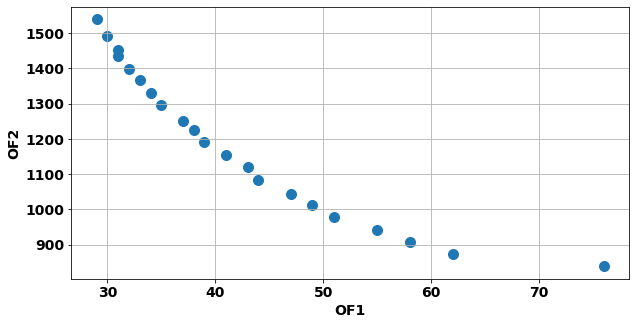

In [15]:
KOLOR = ['r', 'k', 'b', 'g', 'gold', 'pink','dodgerblue','orange','brown','olive']

plt.figure(figsize=(10,5))
plt.xlabel('OF1', fontsize=14, fontweight = 'bold')
plt.ylabel('OF2', fontsize=14, fontweight = 'bold')
plt.xticks(fontsize=14, fontweight = 'bold')
plt.yticks(fontsize=14, fontweight = 'bold')

plt.scatter(OF1_vec,OF2_vec, s=100)
Yi = [i for i in instance.i]
plt.grid()
plt.savefig('Pareto'+  ' .png', format='png', dpi=200)
plt.show()
